In [1]:
import os
import torch
from models.wta_cnp import WTA_CNP


root_path = "/home/yigit/projects/mbcnp/outputs/experimental/62D/"
run_id, model_folder = f'1700927469', 'saved_models/'
run_folder = f'{root_path}{run_id}/'
models_path = f'{run_folder}{model_folder}'

wta_model_path = f'{models_path}wta_on_synth.pt'

y = torch.load(f'{run_folder}y.pt').cpu()
num_samples, t_steps, dy = y.shape
dx = 1
batch_size = 1

x = torch.linspace(0, 1, t_steps).repeat(batch_size, 1).view(batch_size, -1, 1)
colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

wta = WTA_CNP(1, dy, 10, 10, [512, 512, 512], num_decoders=1, decoder_hidden_dims=[512, 512, 512], batch_size=batch_size)

wta.load_state_dict(torch.load(wta_model_path))
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=63, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoders): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=513, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=124, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [2]:
def get_batch(idx=[0], cond_idx=[0]):
    batch_obs = torch.zeros(batch_size, len(cond_idx), dy+dx, dtype=torch.float32)
    batch_obs[:, :, 0] = x[0, cond_idx, 0]

    batch_obs[:, :, 1:] = y[idx, cond_idx, :].view(batch_size, len(cond_idx), dy)
    
    return batch_obs, y[idx, :, :]

In [3]:
test_ind = 0
tar = torch.linspace(0, 1, t_steps).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, 1)

obs, real_y = get_batch(list(range(batch_size)), [test_ind])

print(obs.shape, real_y.shape, tar.shape)

with torch.no_grad():
    pred_wta, gate = wta(obs, tar)

out_traj = pred_wta[0, 0, :, :dy].cpu().numpy()

torch.Size([1, 1, 63]) torch.Size([1, 781, 62]) torch.Size([1, 781, 1])


In [4]:
print(out_traj.shape)

(781, 62)


In [5]:
def replace_amc_values(original_file, out_traj, new_file):
    with open(original_file, 'r') as f, open(new_file, 'w') as new_f:
        lines = f.readlines()
        d_ctr = 0
        for i, line in enumerate(lines):
            # Skip header lines
            if i < 3:
                new_f.write(line)
                continue

            # Split the line into parts
            parts = line.split()
            if len(parts) > 1:
                # Replace the numeric values
                new_parts = [parts[0]]
                for j in range(len(parts)-1):
                    new_parts.append(str(out_traj[frame_id-1, d_ctr]))
                    d_ctr = (d_ctr + 1) % dy
                new_line = ' '.join(new_parts) + '\n'
                new_f.write(new_line)
            else:
                frame_id = int(parts[0])
                new_f.write(line)

replace_amc_values(f'{run_folder}out.amc', out_traj, f'{run_folder}new.amc')

In [6]:
print(out_traj[-1])

[ 1.58086300e+00  1.79608345e+01  2.82689686e+01  3.59414307e+02
 -8.41227417e+01  8.42250824e+00 -5.30872059e+00  5.06353974e-01
 -1.09459162e+00 -2.94482136e+00  6.68586135e-01 -1.75090170e+00
 -3.83535624e-02  2.93016970e-01 -1.19427586e+00  6.32107735e-01
 -2.56084156e+00 -9.72723961e-02  3.71735573e-01 -3.42914844e+00
  3.13607812e+00  5.81014156e-02 -1.73109579e+00  9.74600136e-01
  4.91065904e-04  3.64640728e-04 -1.63495579e+01 -2.01191254e+01
 -2.49258041e+00  2.63806171e+01  1.14302855e+01  1.10099125e+00
 -4.71856308e+01  7.12635136e+00  2.66477509e+01 -4.34622589e+02
 -2.13342719e-04  1.02225691e-04  9.07450676e-01  1.22488842e+01
  7.54243994e+00  2.37161674e+01  1.02154279e+00 -1.75466232e+01
 -1.29258947e+01  7.12439156e+00  8.70207882e+00  1.68407326e+01
  9.93822384e+00  2.41189995e+01  1.05382214e+01 -5.37151051e+00
 -4.23995285e+01 -3.54376450e+01  1.74451408e+01  6.49754286e+00
 -1.27732315e+01 -8.11125851e+00 -5.45988750e+00 -3.06649628e+01
  4.48515701e+00  4.64753

In [10]:
import time

from absl import app
from absl import flags
from dm_control.suite import humanoid_CMU
from dm_control.suite.utils import parse_amc
import matplotlib.pyplot as plt
import numpy as np

def play():
    env = humanoid_CMU.stand()

    max_num_frames = 90

    # Parse and convert specified clip.
    converted = parse_amc.convert(f'{run_folder}new.amc',
                                  env.physics, env.control_timestep())

    max_frame = max(max_num_frames, converted.qpos.shape[1] - 1)
    print('Plotting {} frames.'.format(max_frame))

    width = 240
    height = 240
    video = np.zeros((max_frame, height, width, 3), dtype=np.uint8)

    for i in range(max_frame):
      p_i = converted.qpos[:, i]
      with env.physics.reset_context():
        env.physics.data.qpos[:] = p_i
      video[i] = env.physics.render(height, width, camera_id=1)

  
    # for i in range(1, max_frame):
    #     img = plt.imshow(video[i])
    #     plt.title(i)
    #     plt.pause(0.01)  # Need min display time > 0.0.
    #     plt.draw()

    return converted, video

converted, video = play()

Plotting 325 frames.


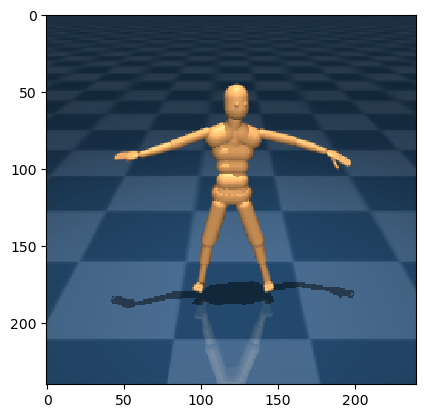

In [16]:
%matplotlib inline

import matplotlib.animation as animation

def update_frame(i):
    img.set_array(video[i])
    return img,

# Create the initial plot.
fig = plt.figure()
img = plt.imshow(video[0])

ani = animation.FuncAnimation(fig, update_frame, frames=324, interval=30, blit=True)

plt.show()

In [13]:
# import dm_control.locomotion as locomotion
# from dm_control import composer

# walker = locomotion.walkers.cmu_humanoid.CMUHumanoid()
# arena = locomotion.arenas.Floor()
# task = locomotion.tasks.stand.Stand(walker=walker, arena=arena)
# env = composer.Environment(task=task, random_state=None)

# walker = locomotion.walkers.cmu_humanoid.CMUHumanoid()
# arena = locomotion.arenas.Floor()
# task = locomotion.tasks.stand.Stand(walker=walker, arena=arena)
# env = composer.Environment(task=task, random_state=None)


# qpos_init = env.physics.bind(walker.qpos).data
# qvel_init = env.physics.bind(walker.qvel).data

# # Set the initial joint positions and velocities based on the first (qpos, qvel) tuple from the list
# qpos_init[:] = converted.qpos[0][0]
# qvel_init[:] = converted.qvel[0][1]

# viewer = locomotion.viewers.MujocoViewer(env)
# viewer.launch()

# for i, data in enumerate(converted):
#     qpos_target = data[0]
#     qvel_target = data[1]

#     # Set the target joint positions and velocities
#     qpos_init[:] = qpos_target
#     qvel_init[:] = qvel_target

#     # Step the environment and record the next state
#     for _ in range(100):
#         env.step(env.random.uniform(env.action_spec().minimum, env.action_spec().maximum))

from dm_control import mjcf
import mujoco
import numpy as np

# Load the MuJoCo model
model = mjcf.from_path("/home/yigit/.local/lib/python3.8/site-packages/dm_control/suite/humanoid_CMU.xml")
d = mujoco.MjData(model)
sim = mujoco.MjSim(model)

with mujoco.viewer.launch_passive(model, d) as viewer:
  start = time.time()
  while viewer.is_running() and time.time() - start < 30:
    step_start = time.time()

    # mj_step can be replaced with code that also evaluates
    # a policy and applies a control signal before stepping the physics.
    mujoco.mj_step(model, d)

    # Example modification of a viewer option: toggle contact points every two seconds.
    with viewer.lock():
      viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)

    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

# # Simulate the motion
# for qpos, qvel, time in motion_data:
#     sim.data.qpos[:len(qpos)] = qpos
#     sim.data.qvel[:len(qvel)] = qvel
#     sim.forward()
    
#     # Simulate for the specified time duration
#     num_steps = int(time / sim.model.opt.timestep)
#     for _ in range(num_steps):
#         sim.step()

#     # Render or perform other actions as needed
#     sim.render()

# # Close the simulation
# sim.close()



TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. mujoco._structs.MjData(arg0: mujoco._structs.MjModel)

Invoked with: MJCF Element: <mujoco model="humanoid_CMU">...</mujoco>

In [ ]:
# from dm_control.locomotion.walkers.cmu_humanoid import _POSITION_ACTUATORS

# #dm_control_dim_id: mocap_dim_id
# indices = {0:16,1:17,2:18,3:50,4:51,5:52,6:47,7:48,8:49,9:19,
#            10:20,11:21,12:53,13:54,14:55,15:0,16:1,17:2,18:28,19:29,
#            20:38,21:39,22:40,23:41,24:46,25:36,26:37,27:33,28:42,29:43,
#            30:3,31:4,32:13,33:14,34:15,35:22,36:27,37:11,38:12,39:8,
#            40:23,41:24,42:30,43:31,44:32,45:44,46:34,47:35,48:45,49:5,
#            50:6,51:7,52:25,53:9,54:10,55:26}

# dm_traj = torch.zeros((t_steps, 56))
# for i in range(t_steps):
#     for j in range(56):
#         dm_traj[i, j] = torch.tensor(y[0, i, indices[j]]) # / _POSITION_ACTUATORS[indices[j]][1][1]


/tmp/ipykernel_4546/1949910362.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm_traj[i, j] = torch.tensor(y[0, i, indices[j]]) # / _POSITION_ACTUATORS[indices[j]][1][1]


In [49]:
# dm_traj = torch.zeros((t_steps, 56))
# s_traj = y[0, :, :]
# for i in range(t_steps):
#     for j in range(56):
#         dm_traj[i, j] = s_traj[i, indices[j]] / _POSITION_ACTUATORS[indices[j]][1][1]

In [1]:
from dm_control import suite
from dm_control.locomotion.examples import basic_cmu_2019
import numpy as np
from matplotlib import pyplot as plt
from dm_control import viewer

env = basic_cmu_2019.cmu_humanoid_go_to_target()
time_step = env.reset()

action_spec = env.action_spec()

print('action_spec:', action_spec)

width = 480
height = 480
video = np.zeros((698, height, 2 * width, 3), dtype=np.uint8)

# # Step through an episode and print out reward, discount and observation.
# action_spec = env.action_spec()
# time_step = env.reset()

viewer.launch(env)

# # for i in range(698):  # Run for 1000 steps as an example
# #     action = out_traj[i, 6:]
# #     print(action)
# #     break
# #     env.step(action)

for i in range(t_steps):
    action = actions[i, :]
    time_step = env.step(action)
    video[i] = np.hstack([env.physics.render(height, width, camera_id=0),
                          env.physics.render(height, width, camera_id=1)])

# for i in range(t_steps):
#     img = plt.imshow(video[i])
#     plt.pause(0.01)  # Need min display time > 0.0.
#     plt.draw()


action_spec: BoundedArray(shape=(56,), dtype=dtype('float64'), name='walker/headrx\twalker/headry\twalker/headrz\twalker/lclaviclery\twalker/lclaviclerz\twalker/lfemurrx\twalker/lfemurry\twalker/lfemurrz\twalker/lfingersrx\twalker/lfootrx\twalker/lfootrz\twalker/lhandrx\twalker/lhandrz\twalker/lhumerusrx\twalker/lhumerusry\twalker/lhumerusrz\twalker/lowerbackrx\twalker/lowerbackry\twalker/lowerbackrz\twalker/lowerneckrx\twalker/lowerneckry\twalker/lowerneckrz\twalker/lradiusrx\twalker/lthumbrx\twalker/lthumbrz\twalker/ltibiarx\twalker/ltoesrx\twalker/lwristry\twalker/rclaviclery\twalker/rclaviclerz\twalker/rfemurrx\twalker/rfemurry\twalker/rfemurrz\twalker/rfingersrx\twalker/rfootrx\twalker/rfootrz\twalker/rhandrx\twalker/rhandrz\twalker/rhumerusrx\twalker/rhumerusry\twalker/rhumerusrz\twalker/rradiusrx\twalker/rthumbrx\twalker/rthumbrz\twalker/rtibiarx\twalker/rtoesrx\twalker/rwristry\twalker/thoraxrx\twalker/thoraxry\twalker/thoraxrz\twalker/upperbackrx\twalker/upperbackry\twalker/up

NameError: name 't_steps' is not defined